In [1]:
import os
import shutil
import cv2
import random
import albumentations as A
from tqdm.notebook import tqdm
from glob import glob
from shutil import copy2
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
input_dataset = '/kaggle/input/vce-dataset/training'
output_dataset = '/kaggle/working/training_augmented'

In [3]:
heavy_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=90, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
])

medium_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5),
])

light_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5)
])

In [4]:
class_folders = [os.path.join(input_dataset, class_name) for class_name in os.listdir(input_dataset) if os.path.isdir(os.path.join(input_dataset, class_name))]
class_folders

['/kaggle/input/vce-dataset/training/Erythema',
 '/kaggle/input/vce-dataset/training/Foreign Body',
 '/kaggle/input/vce-dataset/training/Bleeding',
 '/kaggle/input/vce-dataset/training/Lymphangiectasia',
 '/kaggle/input/vce-dataset/training/Normal',
 '/kaggle/input/vce-dataset/training/Angioectasia',
 '/kaggle/input/vce-dataset/training/Erosion',
 '/kaggle/input/vce-dataset/training/Ulcer',
 '/kaggle/input/vce-dataset/training/Polyp',
 '/kaggle/input/vce-dataset/training/Worms']

In [18]:
def is_image_file(filename):
    valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    return filename.lower().endswith(valid_extensions)

In [19]:
class_image_counts = {}

for class_name in class_folders:
    class_path = os.path.join(input_dataset, class_name)
    image_files = [f for f in os.listdir(class_path) if is_image_file(f)]
    class_image_counts[class_name] = len(image_files)
    
class_image_counts

{'/kaggle/input/vce-dataset/training/Erythema': 691,
 '/kaggle/input/vce-dataset/training/Foreign Body': 792,
 '/kaggle/input/vce-dataset/training/Bleeding': 834,
 '/kaggle/input/vce-dataset/training/Lymphangiectasia': 796,
 '/kaggle/input/vce-dataset/training/Normal': 28663,
 '/kaggle/input/vce-dataset/training/Angioectasia': 1154,
 '/kaggle/input/vce-dataset/training/Erosion': 2694,
 '/kaggle/input/vce-dataset/training/Ulcer': 663,
 '/kaggle/input/vce-dataset/training/Polyp': 1162,
 '/kaggle/input/vce-dataset/training/Worms': 158}

In [20]:
class_names = [name.replace('/kaggle/input/vce-dataset/training/', '') for name in class_image_counts.keys()]
class_names

['Erythema',
 'Foreign Body',
 'Bleeding',
 'Lymphangiectasia',
 'Normal',
 'Angioectasia',
 'Erosion',
 'Ulcer',
 'Polyp',
 'Worms']

In [21]:
image_counts = list(class_image_counts.values())
image_counts

[691, 792, 834, 796, 28663, 1154, 2694, 663, 1162, 158]

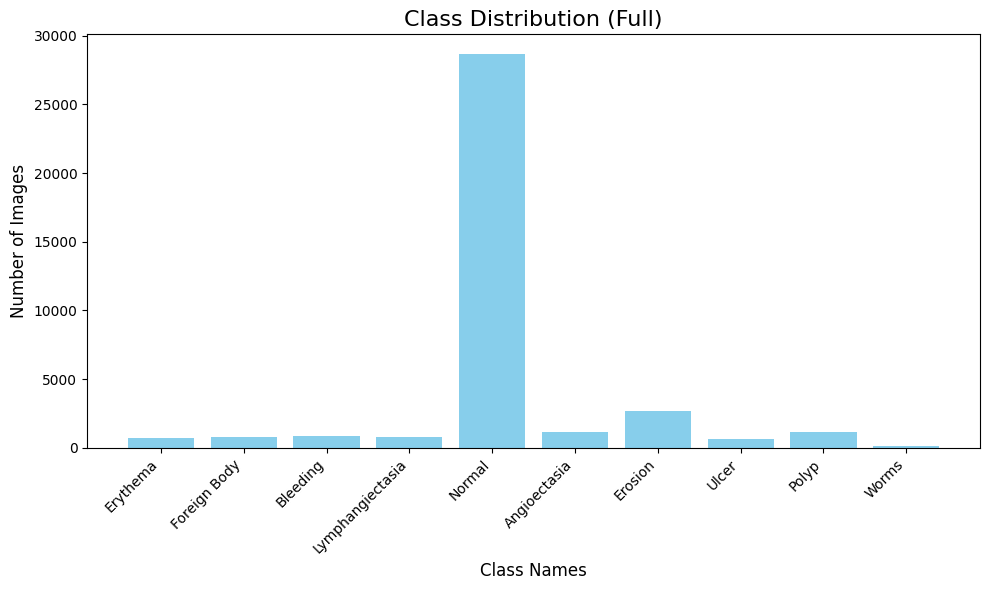

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.title('Class Distribution (Full)', fontsize=16)
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [23]:
filtered_class_names = [name for name in class_names if name != "Normal"]
filtered_image_counts = [count for name, count in zip(class_names, class_image_counts.values()) if name != "Normal"]

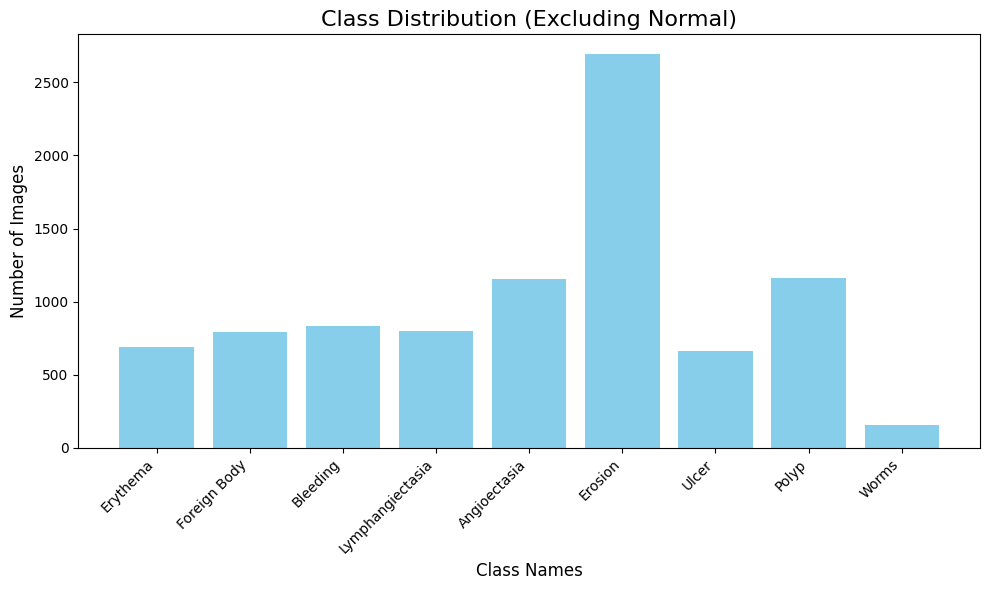

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(filtered_class_names, filtered_image_counts, color='skyblue')
plt.title('Class Distribution (Excluding Normal)', fontsize=16)
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [26]:
class_image_counts = {
    'Erythema': 691,
    'Foreign Body': 792,
    'Bleeding': 834,
    'Lymphangiectasia': 796,
    'Angioectasia': 1154,
    'Erosion': 2694,
    'Ulcer': 663,
    'Polyp': 1162,
    'Worms': 158
}

class_augmentations = {
    'Erythema': 3,
    'Foreign Body': 3,
    'Bleeding': 3,
    'Lymphangiectasia': 3,
    'Normal': 0,  # skipping augmentations for this class
    'Angioectasia': 2,
    'Erosion': 1,
    'Ulcer': 3,
    'Polyp': 2,
    'Worms': 4
}

In [27]:
# shutil.rmtree("/kaggle/working/training_aug.zip")

In [28]:
total_images = sum(class_image_counts.values())

with tqdm(total=total_images, desc="Total Progress", unit="image") as total_bar:
    for class_name, count in class_image_counts.items():
        if class_name == "Normal":
            continue
        
        class_folder_path = os.path.join(input_dataset, class_name)
        output_class_folder = os.path.join(output_dataset, class_name)

        os.makedirs(output_class_folder, exist_ok=True)

        image_list = [img_name for img_name in os.listdir(class_folder_path) if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff'))]
        
        with tqdm(total=len(image_list), desc=f"Processing {class_name}", unit="image") as class_bar:
            for img_name in image_list:
                img_path = os.path.join(class_folder_path, img_name)
                shutil.copy(img_path, output_class_folder)
                image = cv2.imread(img_path)
                
                # apply augmentations based on the class size
                if count < 300:  # less represented class
                    num_augmentations = 10
                    for i in range(num_augmentations):
                        augmented = heavy_augmentations(image=image)
                        augmented_image = augmented['image']
                        cv2.imwrite(os.path.join(output_class_folder, f'aug_{i}_{img_name}'), augmented_image)

                elif count < 1000:  # medium represented class
                    num_augmentations = 4
                    for i in range(num_augmentations):
                        augmented = medium_augmentations(image=image)
                        augmented_image = augmented['image']
                        cv2.imwrite(os.path.join(output_class_folder, f'aug_{i}_{img_name}'), augmented_image)

                else:  # well represented class
                    num_augmentations = 1
                    for i in range(num_augmentations):
                        augmented = light_augmentations(image=image)
                        augmented_image = augmented['image']
                        cv2.imwrite(os.path.join(output_class_folder, f'aug_{i}_{img_name}'), augmented_image)

                # update both class-specific and total progress bars
                class_bar.update(1)
                total_bar.update(1)

print("Augmentation completed, original and augmented images saved!")

Total Progress:   0%|          | 0/8944 [00:00<?, ?image/s]

Processing Erythema:   0%|          | 0/691 [00:00<?, ?image/s]

Processing Foreign Body:   0%|          | 0/792 [00:00<?, ?image/s]

Processing Bleeding:   0%|          | 0/834 [00:00<?, ?image/s]

Processing Lymphangiectasia:   0%|          | 0/796 [00:00<?, ?image/s]

Processing Angioectasia:   0%|          | 0/1154 [00:00<?, ?image/s]

Processing Erosion:   0%|          | 0/2694 [00:00<?, ?image/s]

Processing Ulcer:   0%|          | 0/663 [00:00<?, ?image/s]

Processing Polyp:   0%|          | 0/1162 [00:00<?, ?image/s]

Processing Worms:   0%|          | 0/158 [00:00<?, ?image/s]

Augmentation completed, original and augmented images saved!


In [29]:
def zip_folder(folder_path, output_path_with_name):
    """
    Zips the contents of a folder and saves it as a .zip file.

    Parameters:
    folder_path (str): Path to the folder to be zipped.
    output_path_with_name (str): Full path for the output zip file, including the desired zip file name.
    """
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder '{folder_path}' does not exist.")
    
    if output_path_with_name.endswith('.zip'):
        output_path_with_name = output_path_with_name[:-4]

    shutil.make_archive(output_path_with_name, 'zip', folder_path)
    print(f"Folder '{folder_path}' zipped successfully to '{output_path_with_name}.zip'")

In [30]:
zip_folder("/kaggle/working/training_augmented", "/kaggle/working/training_aug")

Folder '/kaggle/working/training_augmented' zipped successfully to '/kaggle/working/training_aug.zip'


In [31]:
aug_dataset = "/kaggle/working/training_augmented"
class_folders = [os.path.join(aug_dataset, class_name) for class_name in os.listdir(aug_dataset) if os.path.isdir(os.path.join(aug_dataset, class_name))]
class_folders

['/kaggle/working/training_augmented/Foreign Body',
 '/kaggle/working/training_augmented/Polyp',
 '/kaggle/working/training_augmented/Erosion',
 '/kaggle/working/training_augmented/Bleeding',
 '/kaggle/working/training_augmented/Lymphangiectasia',
 '/kaggle/working/training_augmented/Ulcer',
 '/kaggle/working/training_augmented/Erythema',
 '/kaggle/working/training_augmented/Angioectasia',
 '/kaggle/working/training_augmented/Worms']

In [32]:
new_class_image_counts = {}

for class_name in class_folders:
    class_path = os.path.join(aug_dataset, class_name)
    image_files = [f for f in os.listdir(class_path) if is_image_file(f)]
    new_class_image_counts[class_name] = len(image_files)
    
new_class_image_counts

{'/kaggle/working/training_augmented/Foreign Body': 3960,
 '/kaggle/working/training_augmented/Polyp': 2324,
 '/kaggle/working/training_augmented/Erosion': 5388,
 '/kaggle/working/training_augmented/Bleeding': 4170,
 '/kaggle/working/training_augmented/Lymphangiectasia': 3980,
 '/kaggle/working/training_augmented/Ulcer': 3315,
 '/kaggle/working/training_augmented/Erythema': 3455,
 '/kaggle/working/training_augmented/Angioectasia': 2308,
 '/kaggle/working/training_augmented/Worms': 1738}

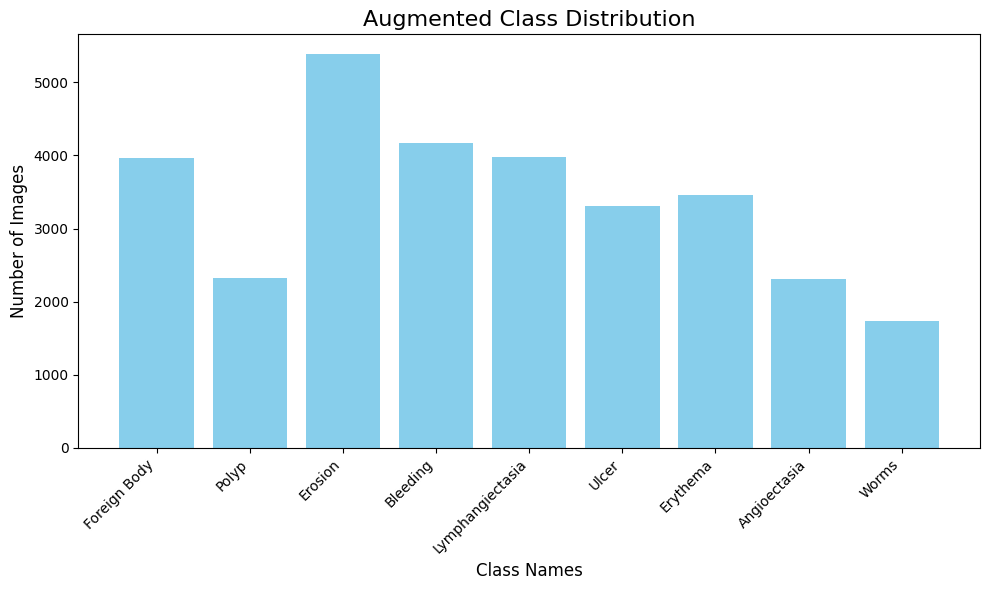

In [33]:
class_names = [name.split('/')[-1] for name in new_class_image_counts.keys()]
image_counts = list(new_class_image_counts.values())

# plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(class_names, image_counts, color='skyblue')
plt.title('Augmented Class Distribution', fontsize=16)
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()